In [1]:
%pylab inline --no-import-all
import cv2
import keras
from keras.layers import *
from keras.models import Sequential
import sys
import os
import skimage
import skimage.transform
import skimage.exposure

Populating the interactive namespace from numpy and matplotlib


Using TensorFlow backend.


(15, 16, 4)


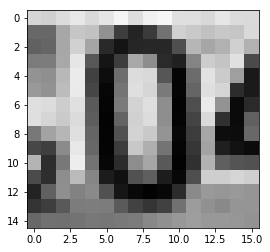

In [139]:
sample_img = plt.imread(os.path.join("symbols/positive", os.listdir("symbols/positive")[0]))
plt.imshow(sample_img)
print(sample_img.shape)

input_dim = sample_img.shape
image_area = input_dim[0] * input_dim

In [175]:
input_dim = sample_img.shape
conv_width = input_dim[1]
conv_height = input_dim[0]
image_area = input_dim[0] * input_dim[1]
first_layer_filters = 16
second_layer_filters = 16

In [164]:
model = Sequential([
    Conv2D(first_layer_filters, (3, 3), padding='same', input_shape=input_dim, activation='relu'),
    Conv2D(second_layer_filters, (3, 3), padding='same', activation='relu'),
    Dropout(0.5),
    Flatten(),
    Dense(second_layer_filters * image_area, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile('adam', 'binary_crossentropy', metrics=['accuracy'])

In [171]:
def train_data_gen(positives_path, negatives_path, batch_size):
    images = []
    labels = []
    X = None
    y = None
    for idx, (pos, neg) in enumerate(zip(os.scandir(positives_path), os.scandir(negatives_path))):
        if pos:
            images.append(plt.imread(pos.path))
            labels.append(1)
                
        if neg:
            images.append(plt.imread(neg.path))
            labels.append(0)

        if len(images) > 0 and len(images) == batch_size:
            X = np.array(images)
            y = np.array(labels)
            images = []
            labels = []
            yield X, y

In [172]:
train_positives = "symbols/positive"
train_negatives = "symbols/negative/"
validation_positives = "symbols/validation/positive/"
validation_negatives = "symbols/validation/negative/"

train_max_count = min([len(os.listdir(train_positives)), len(os.listdir(train_negatives))])
validation_max_count = min([len(os.listdir(validation_positives)), len(os.listdir(validation_negatives))])

batch_size = 100
train_batches = np.floor(train_max_count / batch_size)
validation_batches = np.floor(validation_max_count / batch_size)

model.fit_generator(
    train_data_gen(train_positives, train_negatives, batch_size),
    steps_per_epoch=train_batches,
    epochs=1,
    validation_data=train_data_gen(validation_positives, validation_negatives, batch_size),
    validation_steps=validation_batches
)

Epoch 1/1
  5/102 [>.............................] - ETA: 34s - loss: 0.4201 - acc: 0.9160

KeyboardInterrupt: 

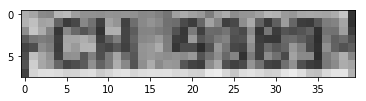

In [176]:
plate = plt.imread("plate.png")
plt.imshow(plate)

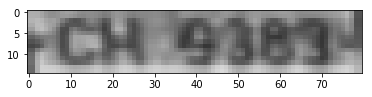

In [178]:
scale = plate.shape[0] / conv_width
resized = skimage.transform.resize(plate, (conv_height, int(plate.shape[1] / scale)), mode='reflect')
plt.imshow(resized)
width = resized.shape[1]
height = resized.shape[0]

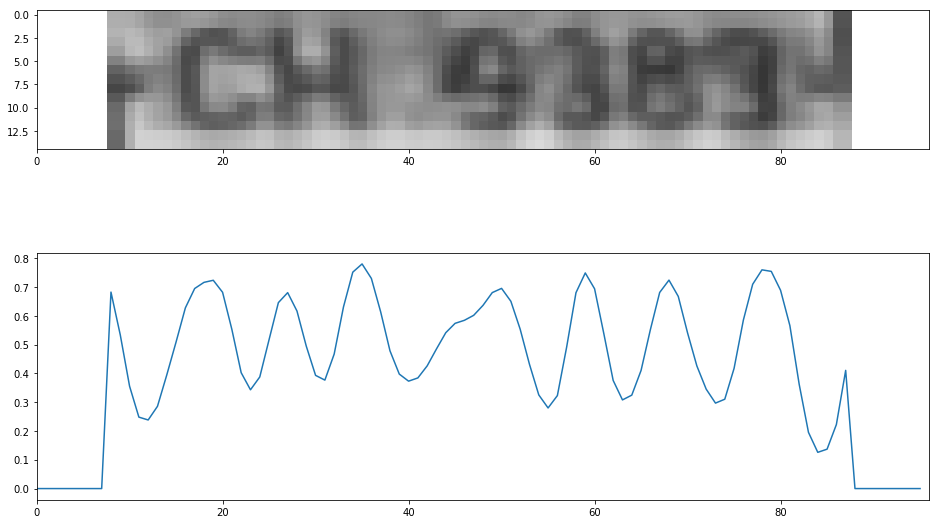

In [190]:
probs = np.zeros((width+conv_width))
half_pad = int(np.ceil(conv_width / 2))

padding = np.zeros((height, int(np.ceil(conv_width/2)), 4))
padded = np.hstack((padding, resized, padding))

for x in range(half_pad, width+half_pad, 1):
    result = model.predict(np.array([padded[:, x-half_pad:x+half_pad, :]]))
    probs[x] = result

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10))
ax1.set_xlim(0, width+conv_width)
ax2.set_xlim(0, width+conv_width)
ax1.imshow(padded)
ax2.plot(probs)

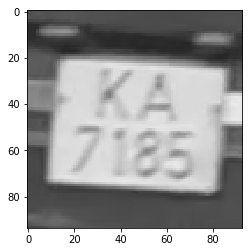

In [136]:
plate = plt.imread("plate2.png")
plt.imshow(plate)

/home/denis/miniconda3/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))


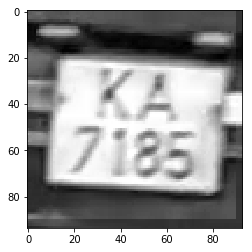

In [137]:
norm = skimage.exposure.equalize_adapthist(plate)
plt.imshow(norm)

In [ ]:
probs = np.zeros((conv_width+16))

padding = np.zeros((15, 8, 4))
padded = np.hstack((padding, resized, padding))
print(conv_width+16)

for x in range(8, conv_width+8, 1):
    result = model.predict(np.array([padded[:, x-8:x+8, :]]))
    probs[x] = result
  #  probs[x+16] = result

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10))
ax1.set_xlim(0, conv_width+16)
ax2.set_xlim(0, conv_width+16)
ax1.imshow(padded)
ax2.plot(probs)